In [7]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import statsmodels.api as sm
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import binomtest, chisquare
import scipy.stats as stats
from statsmodels.stats.proportion import proportion_confint

# Phecode list
rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
rd = rd.loc[rd['Type'] == 'Rare']

# Main function to run logistic regression
def run_lr(df, firstdx, ba):
    results = []
    
    df['intercept'] = 1.0
    independent_vars = ['age', 'gender', 'years_followed', 'years_exposure', 'disease', 'surgery', 'intercept']
    columns_to_test = df.columns.difference(['person_id', 'age', 'gender', 'years_followed', 'years_exposure', 'disease', 
                                             'surgery', 'intercept', 'last_event'])
    
    for col in columns_to_test:
        firstdx_col = firstdx.loc[firstdx['gene_moa'] == col].reset_index(drop=True)['drug_start'][0]
        df_filt = df.loc[df['last_event'] >= (firstdx_col + pd.Timedelta(365, 'days'))]
        df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
        df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
        
        ba_filt = df_filt.loc[(df_filt['disease'] == 1) & (df_filt[col] == 1)]
        ba_filt = ba.loc[(ba['person_id'].isin(ba_filt['person_id'])) & (ba['gene_moa'] == col)]
        
        dependent_var = df_filt[col]
        count = dependent_var.sum()
        count_case = df_filt.loc[df_filt['disease'] == 1][col].sum()
        if len(ba_filt) > 0:
            count_case_before = ba_filt['before'].sum()
            count_case_after = ba_filt['after'].sum()
            years_before = ba_filt['years_before_dx'].mean()
            years_after = ba_filt['years_after_dx'].mean()
        else:
            count_case_before = 0
            count_case_after = 0
            years_before = 0
            years_after = 0
        n_case = df_filt['disease'].sum()
        count_ctrl = df_filt.loc[df_filt['disease'] == 0][col].sum()
        n_ctrl = len(df_filt.loc[df_filt['disease'] == 0])

        if (count_case >= 5) & (count_ctrl >= 1) & (count >= 10):
            try:   
                model = sm.Logit(dependent_var, df_filt[independent_vars])
                result = model.fit(disp=0, maxiter=100)
                
                odds_ratio = np.exp(result.params['disease'])
                conf = result.conf_int().loc['disease']
                conf_interval = np.exp(conf)
                p_value = result.pvalues['disease']

                results.append({
                    'gene_moa': col,
                    'first_dx': firstdx_col,
                    'count': count,
                    'count_case': count_case,
                    'count_case_before': count_case_before,
                    'count_case_after': count_case_after,
                    'years_before': years_before,
                    'years_after': years_after,
                    'n_case': n_case,
                    'count_ctrl': count_ctrl,
                    'n_ctrl': n_ctrl,
                    'or': odds_ratio,
                    'or_lower': conf_interval[0],
                    'or_upper': conf_interval[1],
                    'p_value': p_value
                })
            except:
                results.append({
                    'gene_moa': col,
                    'first_dx': firstdx_col,
                    'count': count,
                    'count_case': count_case,
                    'count_case_before': count_case_before,
                    'count_case_after': count_case_after,
                    'years_before': years_before,
                    'years_after': years_after,
                    'n_case': n_case,
                    'count_ctrl': count_ctrl,
                    'n_ctrl': n_ctrl,
                    'or': np.nan,
                    'or_lower': np.nan,
                    'or_upper': np.nan,
                    'p_value': np.nan
                })
        else:
            results.append({
                'gene_moa': col,
                'first_dx': firstdx_col,
                'count': count,
                'count_case': count_case,
                'count_case_before': count_case_before,
                'count_case_after': count_case_after,
                'years_before': years_before,
                'years_after': years_after,
                'n_case': n_case,
                'count_ctrl': count_ctrl,
                'n_ctrl': n_ctrl,
                'or': np.nan,
                'or_lower': np.nan,
                'or_upper': np.nan,
                'p_value': np.nan
            })  
        
    return pd.DataFrame(results)

## Analyze results (see code to run analysis below this section)

In [8]:
folder_path = './LR'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]

df_list = [pd.read_pickle(os.path.join(folder_path, file)) for file in all_files]
df = pd.concat(df_list, ignore_index=True)


In [9]:
# Filtering on drug mechanisms with at least 5 cases and where OR not NaN
temp = df.loc[df['count_case'] >= 5]
temp = temp.loc[temp['or'].notna()]

# Removing non-strict definition of mechanisms
# Non-strict = merging drugs together if they modulate a single gene in the same direction, even if each drug also has its own unique targets
# Strict = merging drugs together only if all of their targets/directions are shared
temp = temp.loc[~(temp['type'] == 'Non-approved prioritized mechanisms')]

# Fixing some labeling mistakes
temp.loc[temp['gene_moa'].isin(['Amoxicillin','Oseltamivir']), 'type'] = 'Non-approved non-prioritized mechanisms (strict)'
temp.loc[temp['gene_moa'].isin(['Amoxicillin','Oseltamivir']), 'prediction'] = 0
temp.loc[temp['gene_moa'] == 'Amoxicillin', 'name'] = "['amoxicillin']"
temp.loc[(temp['gene_moa'].str.contains('FGFR2')) & (temp['type'].str.contains('strict')) & (temp['phecode'] == 'RE_477.2'), 'type'] = 'Approved mechanisms'
temp.loc[(temp['name'].astype(str).str.contains('acetazolamide|methazolamide')) & (temp['type'].str.contains('strict')) & (temp['phecode'] == 'NS_344.2'), 'type'] = 'Approved mechanisms'

# Exclude reproductive drugs due to confounding
temp = temp.loc[~((temp['type'] != 'Approved mechanisms') & (temp['name'].astype(str).str.contains('oxytocin|orgestrel|estradiol|methylergonovine|tranexamic|drospirenone')))]

temp = temp.loc[~(temp['type'] == 'Control mechanisms')]
temp['bh_p'] = multipletests(temp['p_value'], method='fdr_bh')[1]
temp['log10p'] = -np.log10(temp['bh_p'])
temp.loc[temp['log10p'] > 326, 'log10p'] = 326

print(temp['type'].value_counts())
print(temp['phecode'].nunique())

temp = temp.merge(rd[['phecode','phecode_string']])
temp = temp.loc[temp['log10p'] >= 0.001]

temp['years_after'] = temp['years_after']*1.1
temp['expected_before'] = (temp['years_before'] / (temp['years_before'] + temp['years_after'])) * temp['count_case']
temp['expected_after'] = (temp['years_after'] / (temp['years_before'] + temp['years_after'])) * temp['count_case']
temp['prop_after'] = temp['count_case_after']/temp['count_case']
temp['expected_prop_after'] = temp['expected_after']/temp['count_case']

temp['binom_p_value'] = temp.apply(
    lambda row: binomtest(
        k=int(row['count_case_before']),  # total prescriptions observed
        n=int(row['count_case']),  # total trials (same as count_case in this context)
        p=row['years_before'] / (row['years_before'] + row['years_after']),  # expected proportion before diagnosis
        alternative='two-sided'
    ).pvalue, axis=1
)

temp['oe_after'] = temp['prop_after']/temp['expected_prop_after']
temp['log10p_binomial'] =  -np.log10(temp['binom_p_value'])


/sc/arion/projects/GENECAD/Robert/conda/envs/test/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


type
Non-approved prioritized mechanisms (strict)        6158
Non-approved non-prioritized mechanisms (strict)    3378
Approved mechanisms                                  427
Name: count, dtype: int64
161


In [10]:
np_thresh = temp.loc[temp['type'] == 'Non-approved non-prioritized mechanisms (strict)'].sort_values('or')
np_thresh = np_thresh.loc[np_thresh['or'] < 1]
np_thresh_lower = np_thresh[:round(len(np_thresh)*0.1)]['or'].max() # np_thresh['or'].quantile(0.05)

np_thresh = temp.loc[temp['type'] == 'Non-approved non-prioritized mechanisms (strict)'].sort_values('or')
np_thresh = np_thresh.loc[np_thresh['or'] > 1]
np_thresh_upper = np_thresh[:round(len(np_thresh)*0.9)]['or'].max() # np_thresh['or'].quantile(0.95)

print(np_thresh_lower, np_thresh_upper)


0.560568374419972 3.9105093861545974


In [11]:
tt = temp.copy()
tt['OR'] = 'Neither'
tt.loc[(tt['bh_p'] < 0.05) & (temp['or'] <= np_thresh_lower), 'OR'] = 'OR < 0.56\np < 0.05'
tt.loc[(tt['bh_p'] < 0.05) & (temp['or'] >= np_thresh_upper), 'OR'] = 'OR > 3.91\np < 0.05'
tt['O/E'] = 'Neither'
tt.loc[(tt['oe_after'] > 1) & (tt['binom_p_value'] < 0.05), 'O/E'] = 'O/E > 1\np < 0.05'
tt.loc[(tt['oe_after'] < 1) & (tt['binom_p_value'] < 0.05), 'O/E'] = 'O/E < 1\np < 0.05'
tt = tt.dropna(subset=['OR','O/E'])

tt['OR'] = pd.Categorical(tt['OR'], ['OR < 0.56\np < 0.05','Neither','OR > 3.91\np < 0.05'])
tt['O/E'] = pd.Categorical(tt['O/E'], ['O/E < 1\np < 0.05','Neither','O/E > 1\np < 0.05'])

a = tt.loc[(tt['prediction'] < 0.01) & (tt['type'] != 'Approved mechanisms')]
b = tt.loc[(tt['prediction'] > 0.01) & (tt['type'] != 'Approved mechanisms')]
c = tt.loc[tt['type'] == 'Approved mechanisms']


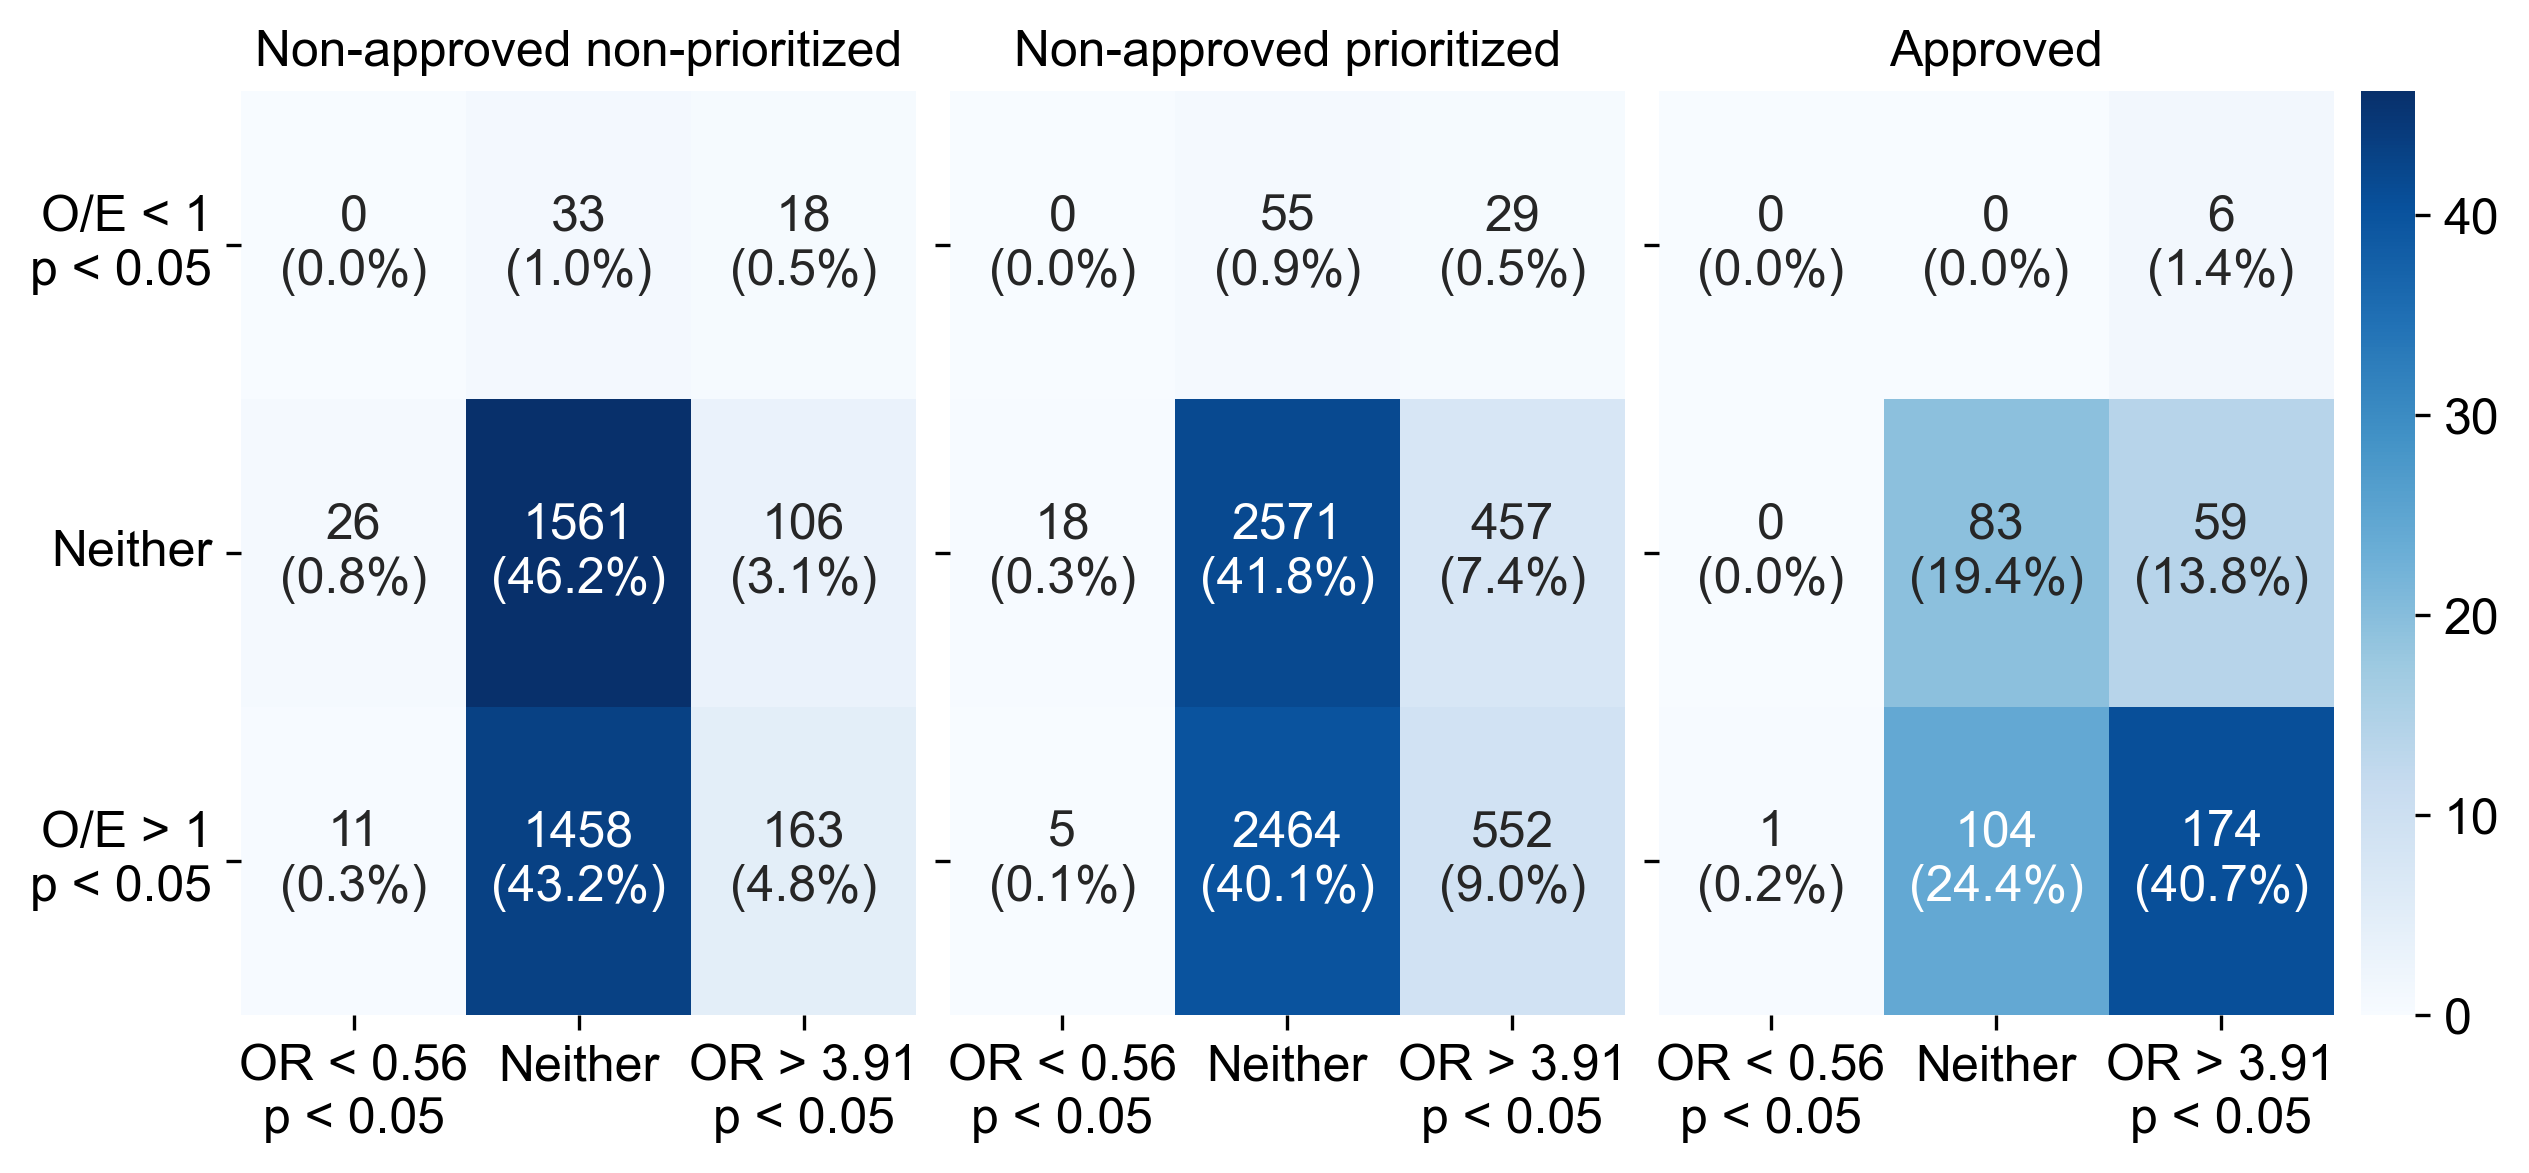

In [12]:
def plot_combined_heatmap(df, title, ax, vmin, vmax):
    count_data = pd.crosstab(df['O/E'], df['OR'])
    percentage_data = count_data / count_data.sum().sum() * 100
    
    annotations = count_data.astype(str) + '\n(' + percentage_data.round(1).astype(str) + '%)'
    
    heatmap = sns.heatmap(percentage_data, annot=annotations, fmt='', cmap='Blues', ax=ax, cbar=False, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Rotate y tick labels for the first axis
    if ax == axes[0]:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    else:
        ax.set_yticklabels([])  

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

vmin = 0
vmax = max(
    (pd.crosstab(a['O/E'], a['OR']) / len(a) * 100).max().max(),
    (pd.crosstab(b['O/E'], b['OR']) / len(b) * 100).max().max(),
    (pd.crosstab(c['O/E'], c['OR']) / len(c) * 100).max().max(),
)

fig, axes = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
plt.subplots_adjust(wspace=0.05)

# Plot for each dataset: a, b, c
plot_combined_heatmap(a, 'Non-approved non-prioritized', axes[0], vmin, vmax)
plot_combined_heatmap(b, 'Non-approved prioritized', axes[1], vmin, vmax)
plot_combined_heatmap(c, 'Approved', axes[2], vmin, vmax)

# Create a separate colorbar
cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77])  # Adjusted to match plot height
cbar = plt.colorbar(axes[2].collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)  # Remove the black outline from the colorbar



In [13]:
dr = pd.read_pickle('/sc/arion/projects/GENECAD/Robert/Drug_Phewas/RareDrug/ML/Predictions/apc_druggable_predictions_cov_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)

temp['Category'] = '0'
temp.loc[temp['prediction'] < dr[:(round(len(dr)*0.75))]['prediction'].min(), 'Category'] = '< 25'
temp.loc[temp['prediction'] >= dr[:(round(len(dr)*0.75))]['prediction'].min(), 'Category'] = '25-50'
temp.loc[(temp['prediction'] >= dr[:(round(len(dr)*0.5))]['prediction'].min()) & (temp['prediction'] <= dr[:(round(len(dr)*0.25))]['prediction'].min()), 'Category'] = '50-75'
temp.loc[temp['prediction'] >= dr[:(round(len(dr)*0.05))]['prediction'].min(), 'Category'] = '95-97'
temp.loc[temp['prediction'] >= dr[:(round(len(dr)*0.03))]['prediction'].min(), 'Category'] = '97-99'
temp.loc[temp['prediction'] >= dr[:(round(len(dr)*0.01))]['prediction'].min(), 'Category'] = '99-99.9'
temp.loc[temp['prediction'] >= dr[:(round(len(dr)*0.001))]['prediction'].min(), 'Category'] = '≥ 99.9'
temp.loc[temp['type'] == 'Approved mechanisms', 'Category'] = 'Approved'
temp['Category'] = pd.Categorical(temp['Category'], ['< 25','25-50','50-75','95-97','97-99','99-99.9','≥ 99.9','Approved'])

temp[['sig_under','sig_over']] = 0
temp.loc[(temp['bh_p'] < 0.05) & (temp['or'] <= np_thresh_lower), 'sig_under'] = 1
temp.loc[(temp['bh_p'] < 0.05) & (temp['or'] >= np_thresh_upper), 'sig_over'] = 1


/tmp/ipykernel_2101742/1381675649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('Category')[condition_col].sum()
/tmp/ipykernel_2101742/1381675649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('Category')[condition_col].sum()


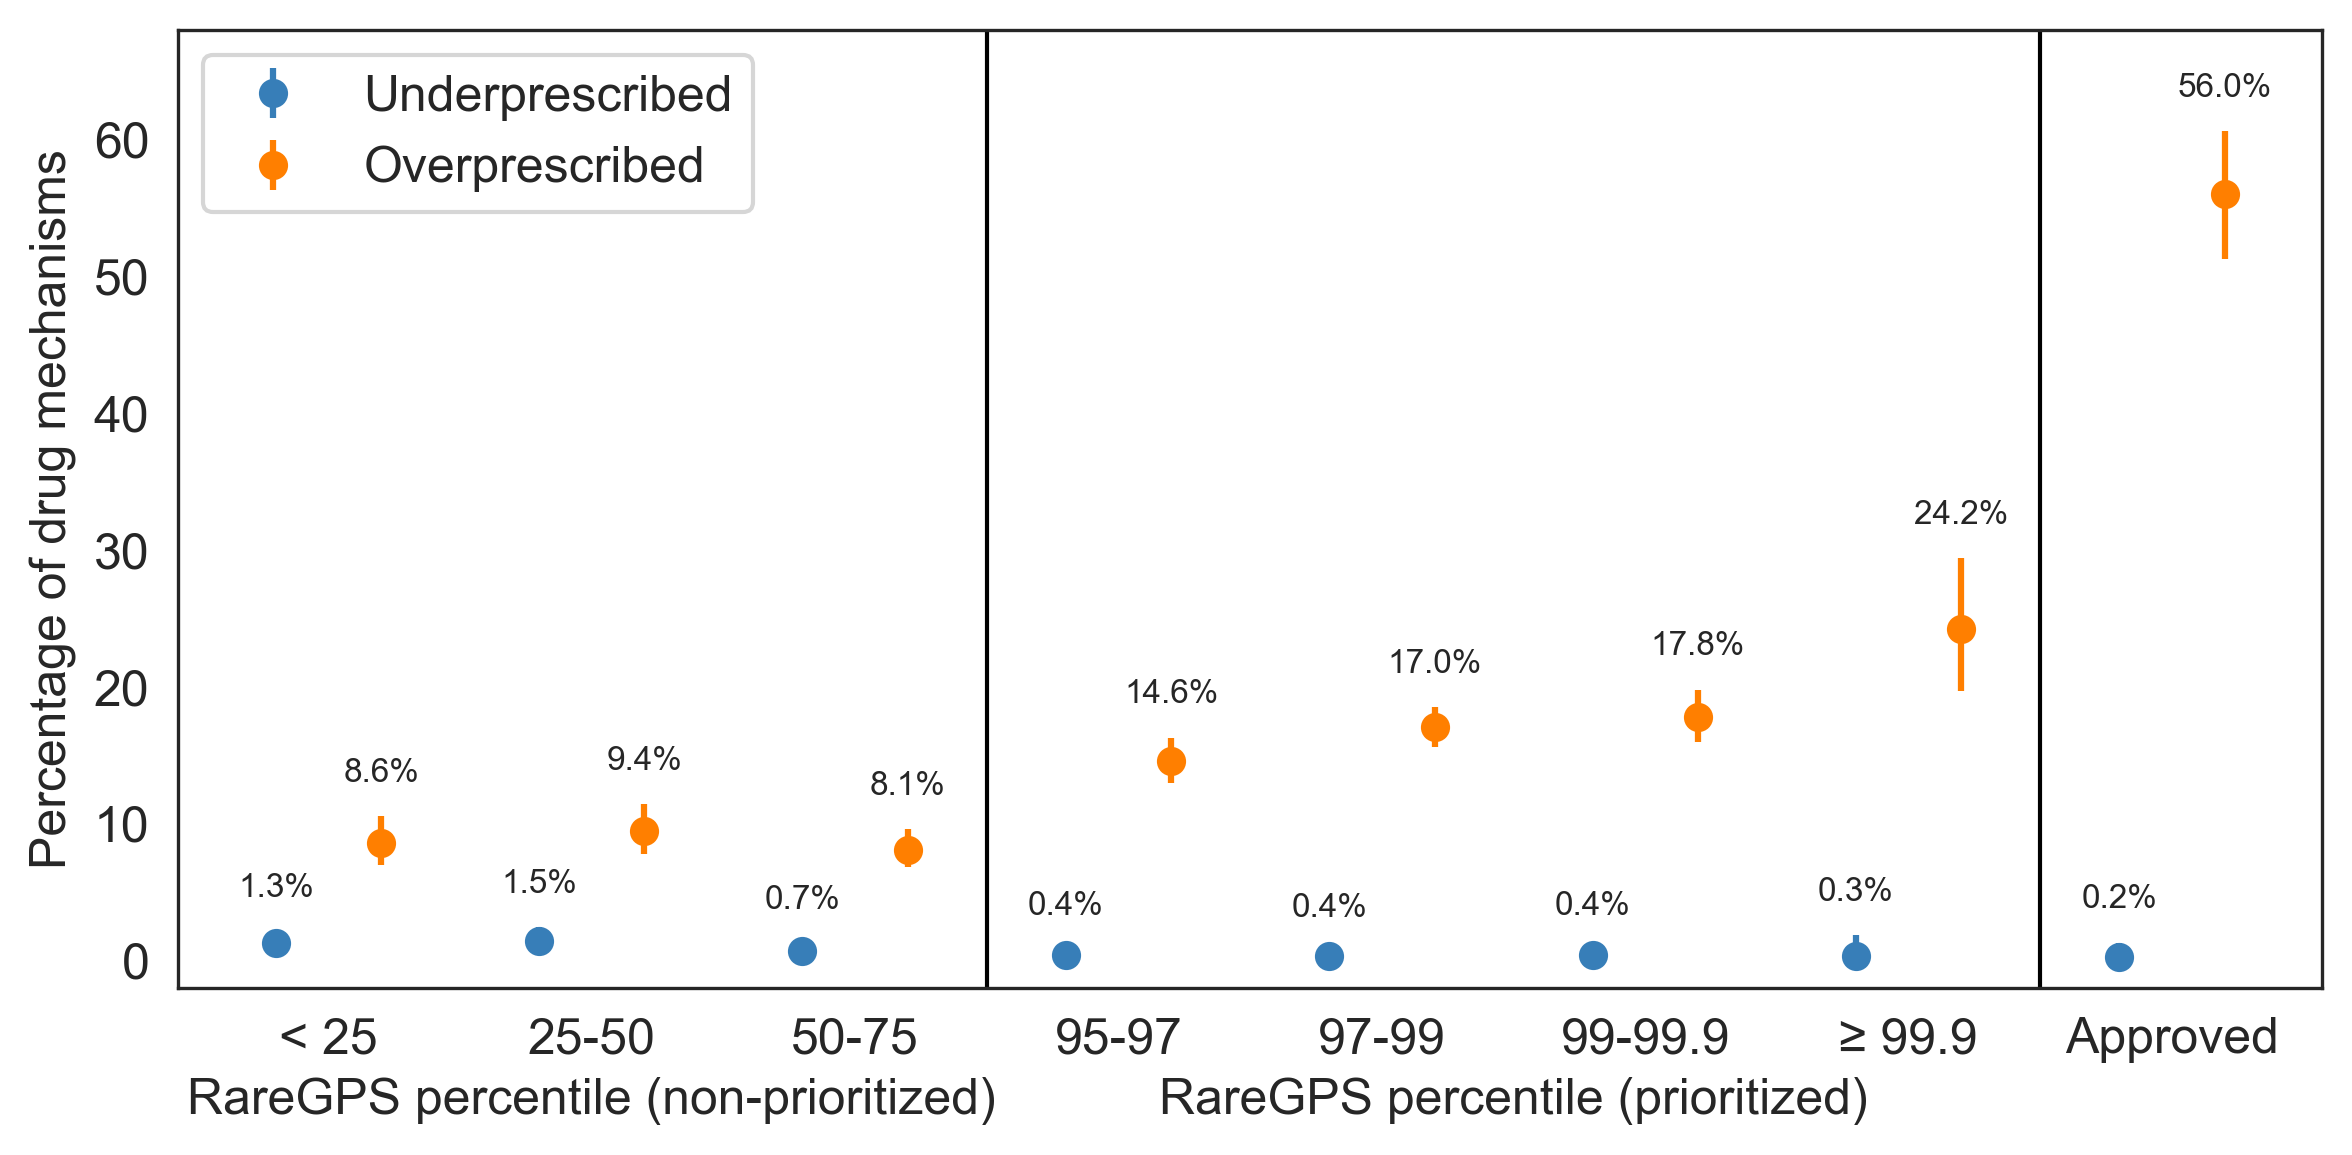

In [14]:
def calculate_wilson_ci(df, condition_col):
    counts = df.groupby('Category')[condition_col].sum()
    nobs = df['Category'].value_counts().reindex(counts.index, fill_value=0)
    prop = counts / nobs
    lower, upper = proportion_confint(counts, nobs, method='wilson')
    return prop * 100, lower * 100, upper * 100  # Convert to percentages

prop_under, lower_under, upper_under = calculate_wilson_ci(temp, 'sig_under')
prop_over, lower_over, upper_over = calculate_wilson_ci(temp, 'sig_over')

categories = temp['Category'].cat.categories
x = np.arange(len(categories))

fig = plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

plt.errorbar(x - 0.2, prop_under, yerr=[prop_under - lower_under, upper_under - prop_under], 
             fmt='o', label='Underprescribed', capsize=0, color=CB_color_cycle[0])
plt.errorbar(x + 0.2, prop_over, yerr=[prop_over - lower_over, upper_over - prop_over], 
             fmt='o', label='Overprescribed', capsize=0, color=CB_color_cycle[1])

# Add text annotations for underprescribed
for i, (p, u) in enumerate(zip(prop_under, upper_under)):
    plt.text(x[i] - 0.2, u + 2, f'{p:.1f}%', ha='center', va='bottom', fontsize=8)

# Add text annotations for overprescribed
for i, (p, u) in enumerate(zip(prop_over, upper_over)):
    plt.text(x[i] + 0.2, u + 2, f'{p:.1f}%', ha='center', va='bottom', fontsize=8)

plt.axvline(x=2.5, linewidth=1, color='black')
plt.axvline(x=6.5, linewidth=1, color='black')

plt.text(1, -8.5, 'RareGPS percentile (non-prioritized)', ha='center', va='top', fontsize=12, transform=plt.gca().transData)
plt.text(4.5, -8.5, 'RareGPS percentile (prioritized)', ha='center', va='top', fontsize=12, transform=plt.gca().transData)

plt.xticks(x, categories, rotation=0)
plt.xlabel('')
plt.ylabel('Percentage of drug mechanisms')
plt.legend(title='')
plt.ylim([-2, 68])  # Adjusted for percentage scale

plt.tight_layout()
plt.show()


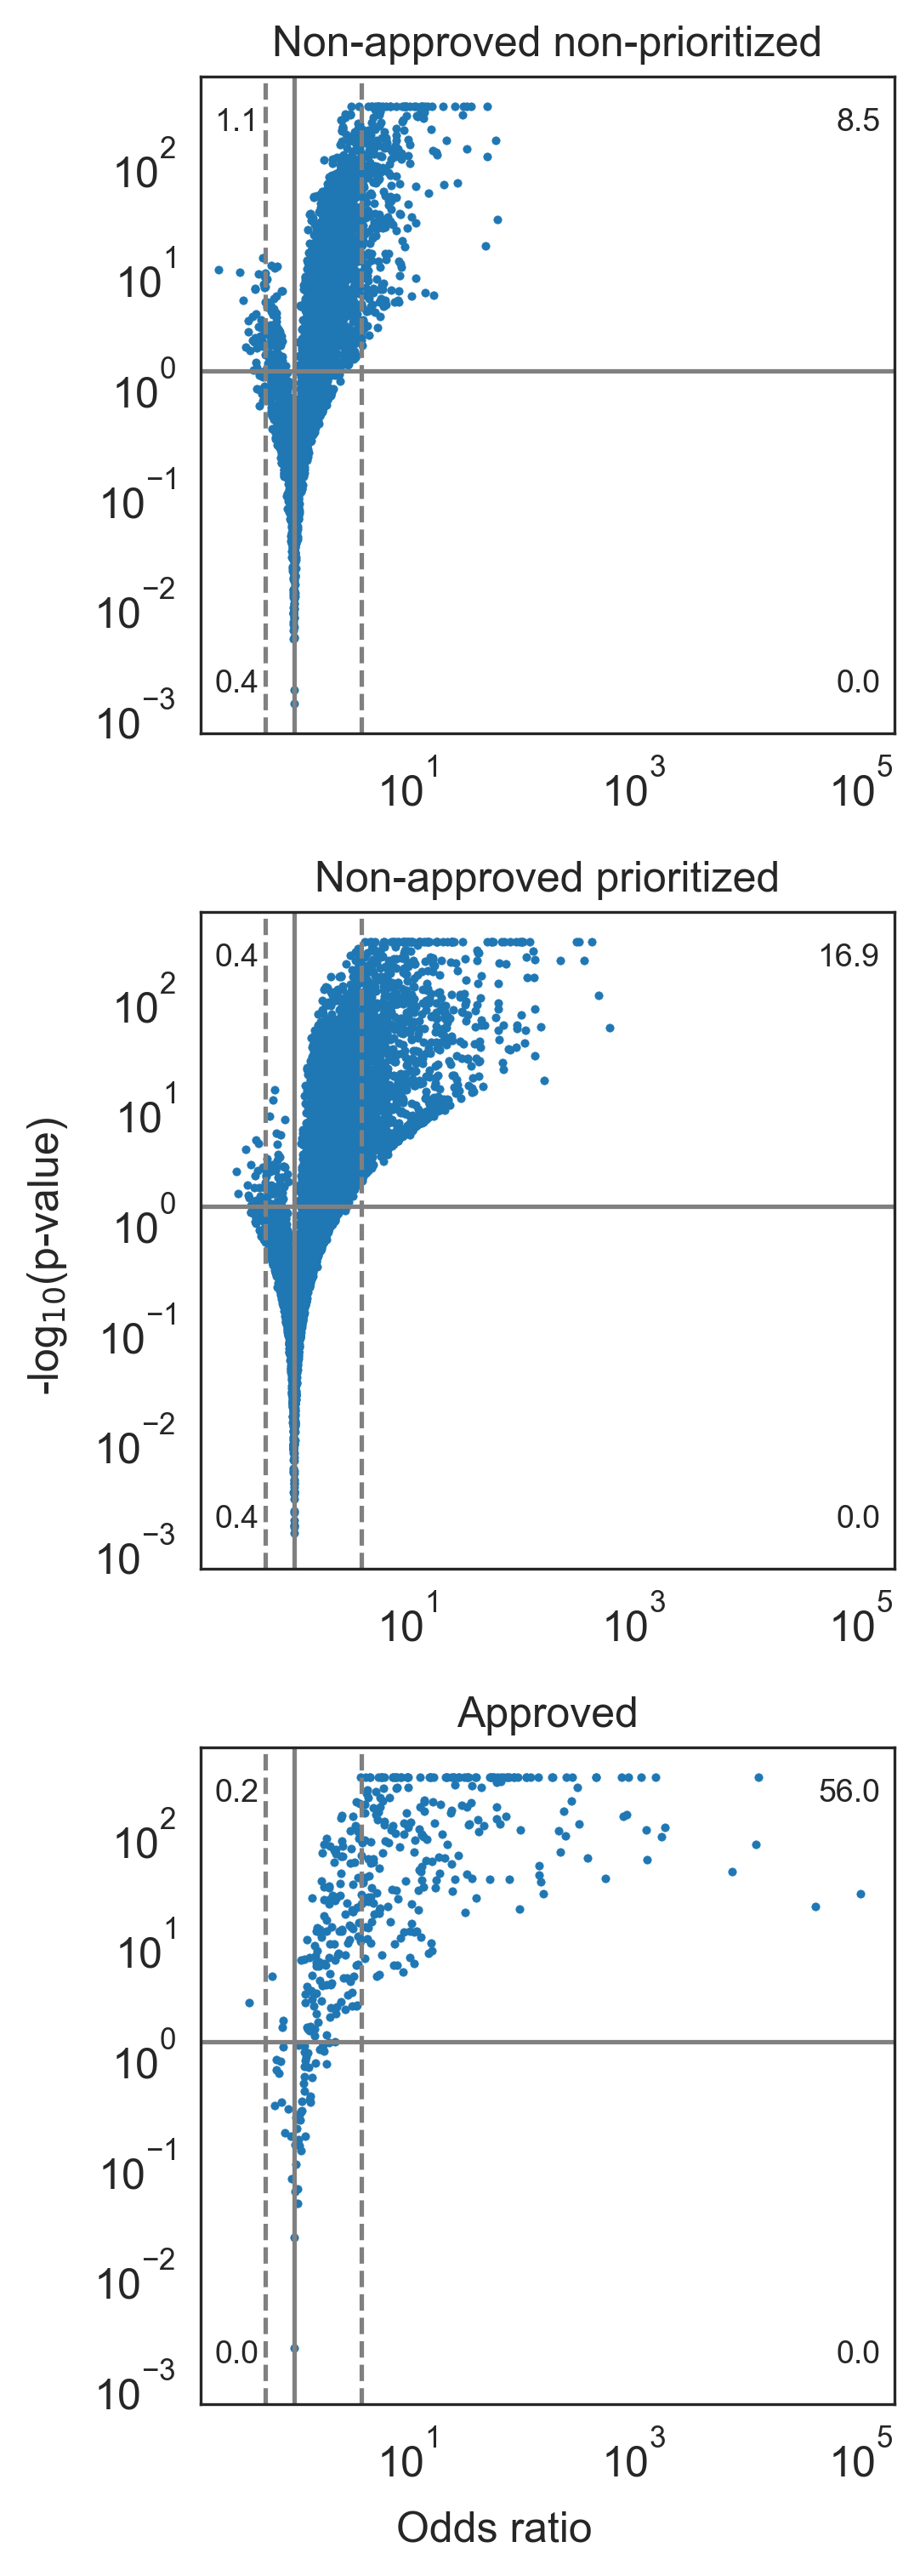

In [15]:
fig, axes = plt.subplots(3,1, figsize=(3.5, 10), dpi=300, sharey=True)  # 1 row, 3 columns

sns.set_style('white')

def annotate_quadrants(ax, data):
    # Calculate the total number of points
    total = len(data)
    # Define quadrants based on vertical and horizontal lines at x=1 and y=1.301
    q1 = len(data[(data['or'] >= np_thresh_upper) & (data['log10p'] > 1.301)])
    q2 = len(data[(data['or'] <= np_thresh_lower) & (data['log10p'] > 1.301)])
    q3 = len(data[(data['or'] <= np_thresh_lower) & (data['log10p'] <= 1.301)])
    q4 = len(data[(data['or'] >= np_thresh_upper) & (data['log10p'] <= 1.301)])
    # Calculate percentages
    percentages = [q1/total * 100, q2/total * 100, q3/total * 100, q4/total * 100]
    # Annotate percentages in each quadrant
    ax.text(1.5e5, 200, f'{percentages[0]:.1f}', ha='right', fontsize=9)
    ax.text(0.2, 200, f'{percentages[1]:.1f}', ha='left', fontsize=9)
    ax.text(0.2, 0.0016, f'{percentages[2]:.1f}', ha='left', fontsize=9)
    ax.text(1.5e5, 0.0016, f'{percentages[3]:.1f}', ha='right', fontsize=9)

# Plot 1: Control mechanisms
data1 = temp.loc[temp['type'] == 'Non-approved non-prioritized mechanisms (strict)']
sns.scatterplot(data=data1, x='or', y='log10p', edgecolor=None, s=5, alpha=1, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xlim([0.15, 2e5])
axes[0].set_title('Non-approved non-prioritized')
axes[0].axvline(x=1, color='gray', linestyle='-', linewidth=1.25)
axes[0].axvline(x=np_thresh_lower, color='gray', linestyle='--', linewidth=1.25)
axes[0].axvline(x=np_thresh_upper, color='gray', linestyle='--', linewidth=1.25)
axes[0].axhline(y=1.301, color='gray', linestyle='-', linewidth=1.25)
annotate_quadrants(axes[0], data1)

# Plot 2: Approved mechanisms
data2 = temp.loc[temp['type'] == 'Non-approved prioritized mechanisms (strict)']
sns.scatterplot(data=data2, x='or', y='log10p', edgecolor=None, s=5, alpha=1, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim([0.15, 2e5])
axes[1].set_title('Non-approved prioritized')
axes[1].axvline(x=1, color='gray', linestyle='-', linewidth=1.25)
axes[1].axvline(x=np_thresh_lower, color='gray', linestyle='--', linewidth=1.25)
axes[1].axvline(x=np_thresh_upper, color='gray', linestyle='--', linewidth=1.25)
axes[1].axhline(y=1.301, color='gray', linestyle='-', linewidth=1.25)
annotate_quadrants(axes[1], data2)

# Plot 3: Non-approved prioritized mechanisms (strict)
data3 = temp.loc[temp['type'] == 'Approved mechanisms']
sns.scatterplot(data=data3, x='or', y='log10p', edgecolor=None, s=5, alpha=1, ax=axes[2])
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_xlim([0.15, 2e5])
axes[2].set_title('Approved')
axes[2].axvline(x=1, color='gray', linestyle='-', linewidth=1.25)
axes[2].axvline(x=np_thresh_lower, color='gray', linestyle='--', linewidth=1.25)
axes[2].axvline(x=np_thresh_upper, color='gray', linestyle='--', linewidth=1.25)
axes[2].axhline(y=1.301, color='gray', linestyle='-', linewidth=1.25)
annotate_quadrants(axes[2], data3)

# Set shared labels
fig.text(0.5, 0, 'Odds ratio', ha='center', va='center')  # X-axis label
fig.text(0, 0.5, '-log$_{10}$(p-value)', ha='center', va='center', rotation='vertical')  # Y-axis label

plt.tight_layout()
plt.show()


/tmp/ipykernel_2101742/4236836036.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[0].set_ylim([0, 400])


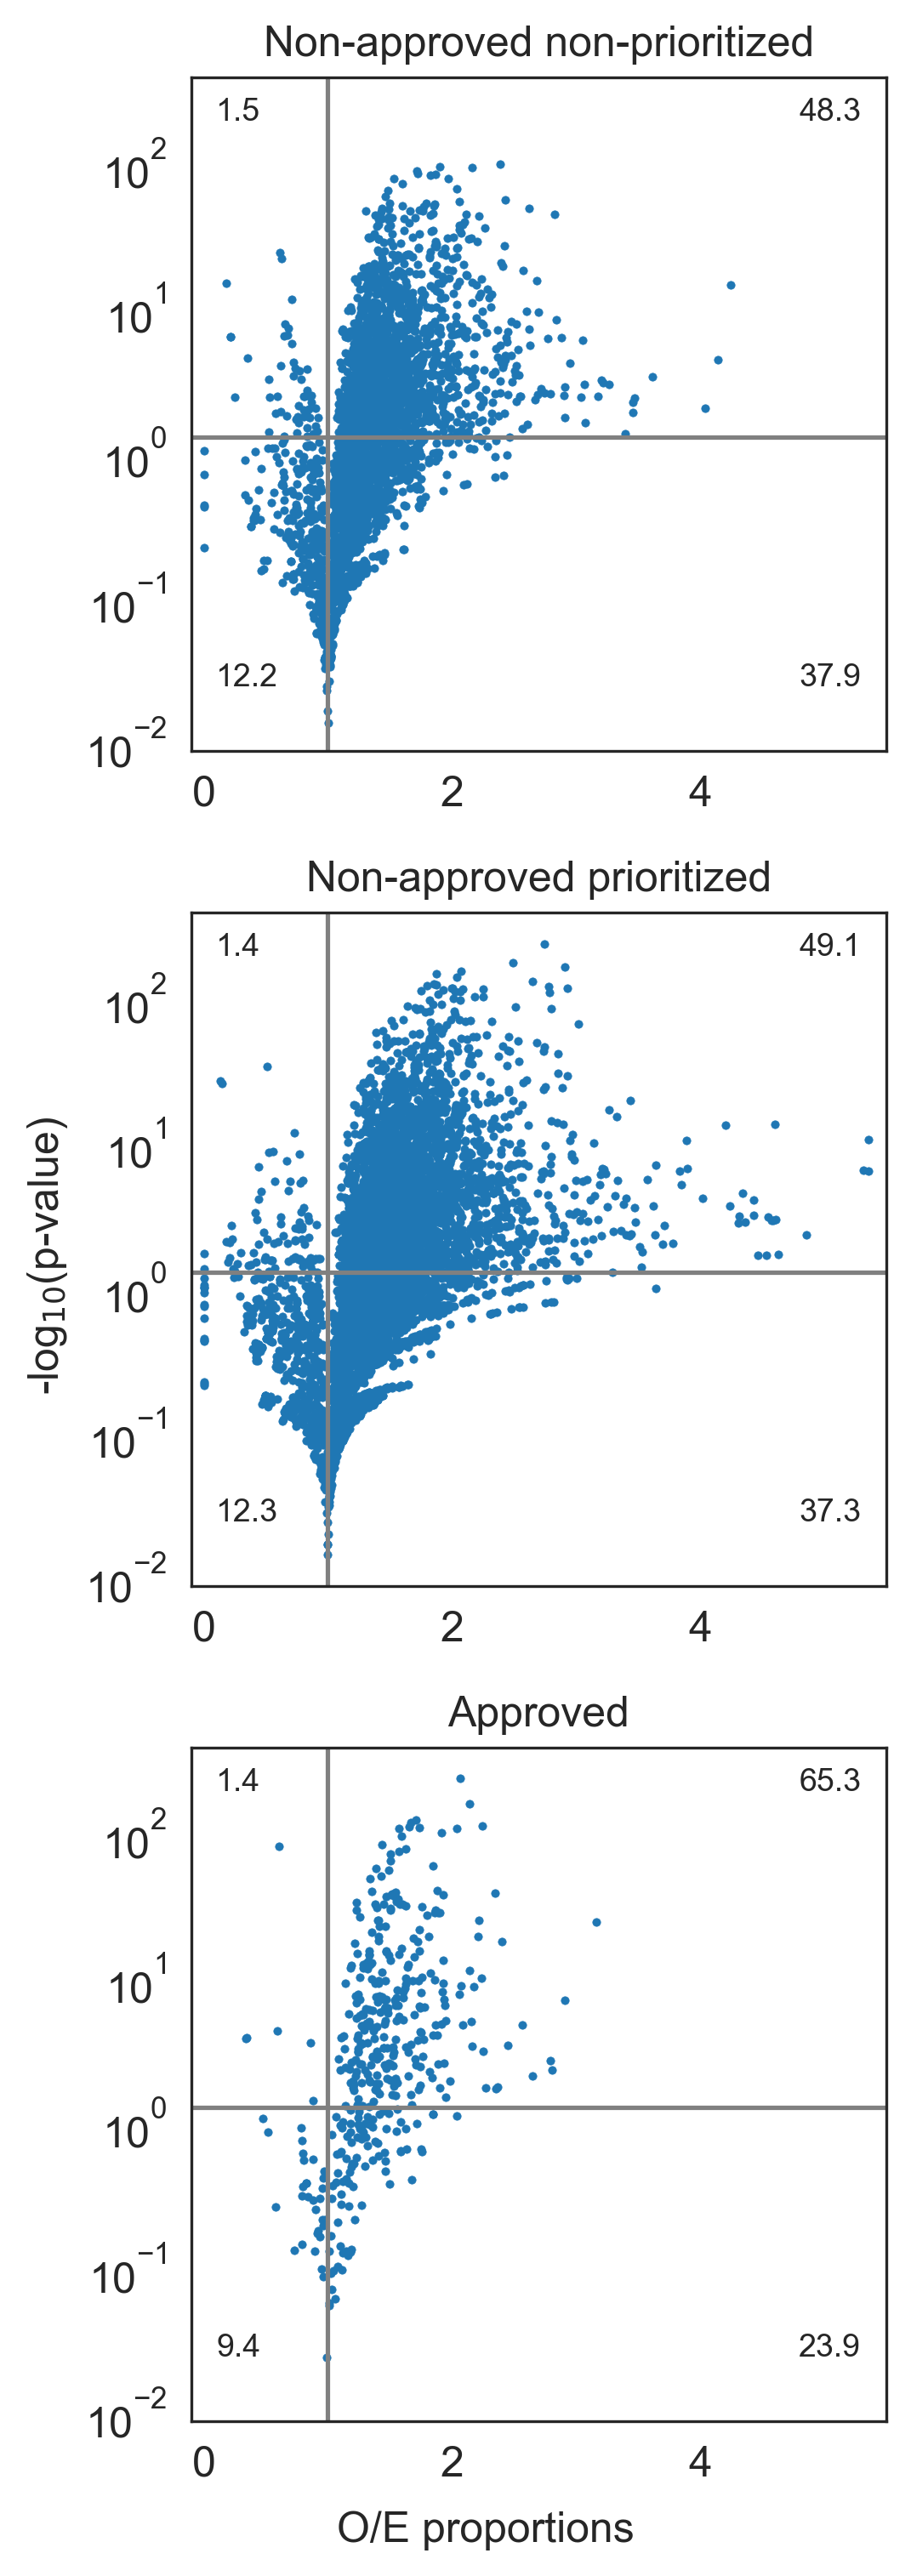

In [16]:
fig, axes = plt.subplots(3,1, figsize=(3.5,10), dpi=300, sharey=True)  # 1 row, 3 columns

sns.set_style('white')

def annotate_quadrants(ax, data):
    # Calculate the total number of points
    total = len(data)
    # Define quadrants based on vertical and horizontal lines at x=1 and y=1.301
    q1 = len(data[(data['oe_after'] > 1) & (data['log10p_binomial'] > 1.301)])
    q2 = len(data[(data['oe_after'] <= 1) & (data['log10p_binomial'] > 1.301)])
    q3 = len(data[(data['oe_after'] <= 1) & (data['log10p_binomial'] <= 1.301)])
    q4 = len(data[(data['oe_after'] > 1) & (data['log10p_binomial'] <= 1.301)])
    # Calculate percentages
    percentages = [q1/total * 100, q2/total * 100, q3/total * 100, q4/total * 100]
    # Annotate percentages in each quadrant
    ax.text(5.3, 200, f'{percentages[0]:.1f}', ha='right', fontsize=9)
    ax.text(0.1, 200, f'{percentages[1]:.1f}', ha='left', fontsize=9)
    ax.text(0.1, 0.025, f'{percentages[2]:.1f}', ha='left', fontsize=9)
    ax.text(5.3, 0.025, f'{percentages[3]:.1f}', ha='right', fontsize=9)

# Plot 1: Control mechanisms
data1 = temp.loc[temp['type'] == 'Non-approved non-prioritized mechanisms (strict)']
sns.scatterplot(data=data1, x='oe_after', y='log10p_binomial', edgecolor=None, s=5, alpha=1, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xlim([-0.1, 5.5])
axes[0].set_ylim([0, 400])
axes[0].set_title('Non-approved non-prioritized')
axes[0].axvline(x=1, color='gray', linestyle='-', linewidth=1.25)
axes[0].axhline(y=1.301, color='gray', linestyle='-', linewidth=1.25)
annotate_quadrants(axes[0], data1)

# Plot 2: Approved mechanisms
data2 = temp.loc[temp['type'] == 'Non-approved prioritized mechanisms (strict)']
sns.scatterplot(data=data2, x='oe_after', y='log10p_binomial', edgecolor=None, s=5, alpha=1, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim([-0.1, 5.5])
axes[1].set_title('Non-approved prioritized')
axes[1].axvline(x=1, color='gray', linestyle='-', linewidth=1.25)
axes[1].axhline(y=1.301, color='gray', linestyle='-', linewidth=1.25)
annotate_quadrants(axes[1], data2)

# Plot 3: Non-approved prioritized mechanisms (strict)
data3 = temp.loc[temp['type'] == 'Approved mechanisms']
sns.scatterplot(data=data3, x='oe_after', y='log10p_binomial', edgecolor=None, s=5, alpha=1, ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_xlim([-0.1, 5.5])
axes[2].set_title('Approved')
axes[2].axvline(x=1, color='gray', linestyle='-', linewidth=1.25)
axes[2].axhline(y=1.301, color='gray', linestyle='-', linewidth=1.25)
annotate_quadrants(axes[2], data3)

# Set shared labels
fig.text(0.5, 0, 'O/E proportions', ha='center', va='center')  # X-axis label
fig.text(0.01, 0.5, '-log$_{10}$(p-value)', ha='center', va='center', rotation='vertical')  # Y-axis label

plt.tight_layout()
plt.show()


## Data cleaning

In [2]:
dem = pd.read_csv('./OMOP/msdw_demographics.csv')

dem['race'] = dem['race_concept_name'].map({
    'White':'White',
    'African American':'Black',
    'Native Hawaiian or Other Pacific Islander':'Asian',
    'Chinese':'Asian',
    'Asian Indian':'Other',
    'Mixed racial group':'Other',
    'Asian':'Asian',
    'Bangladeshi':'Asian',
    'Japanese':'Asian',
    'Korean':'Asian',
    'African':'Black',
    'Haitian':'Black',
    'Filipino':'Asian',
    'Jamaican':'Black',
    'American Indian or Alaska Native':'Native American',
    'Pakistani':'Asian',
    'Dominica Islander':'Black',
    'West Indian':'Black',
    'Laotian':'Asian',
    'Trinidadian':'Black',
    'Other Pacific Islander':'Asian',
    'Vietnamese':'Asian',
    'Taiwanese':'Asian',
    'Nepalese':'Asian',
    'Barbadian':'Black',
    'Indonesian':'Asian',
    'Thai':'Asian',
    'Micronesian':'Asian',
    'Okinawan':'Asian',
    'Burmese':'Asian',
    'Cambodian':'Asian',
    'Sri Lankan':'Asian',
    'Polynesian':'Asian',
    'Melanesian':'Asian',
    'Malaysian':'Asian',
    'Singaporean':'Asian',
    'Bhutanese':'Asian',
    'Madagascar':'Black',
    'Hmong':'Asian',
    'Maldivian':'Asian',
    'Iwo Jiman':'Asian'
})

dem.loc[dem['race_source_value'] == 'Hispanic/Latino', 'race'] = 'Hispanic'
dem.loc[dem['ethnicity_source_value'] == 'Hispanic or Latino', 'race'] = 'Hispanic'
dem.loc[dem['ethnicity_concept_name'] == 'Hispanic or Latino', 'race'] = 'Hispanic'

dem['race'] = dem['race'].fillna('Other')

dem = dem[['person_id','xtn_birth_date','xtn_vital_status_source_concept_name','gender_concept_code','race','xtn_three_digit_zip']]
dem = dem.set_axis(['person_id','dob','vital_status','gender','race','zip'],axis=1)

dem.to_pickle('./Cleaned/person.pkl')


/tmp/ipykernel_266307/2931058797.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dem = pd.read_csv('./OMOP/msdw_demographics.csv')


In [2]:
flo = pd.read_csv('./OMOP/msdw_first_last_outpatient.csv')
flo = flo.set_axis(['person_id','first_outpatient','last_outpatient'],axis=1)
fla = pd.read_csv('./OMOP/msdw_first_last_any_visit.csv')
fla = fla.set_axis(['person_id','first_visit','last_visit'],axis=1)
fm = pd.read_csv('./OMOP/msdw_first_last_medication.csv')
fm = fm.set_axis(['person_id','first_med','last_med'],axis=1)
fd = pd.read_csv('./OMOP/msdw_first_last_co.csv')
fd = fd.set_axis(['person_id','first_dx','last_dx'],axis=1)

dem = pd.read_pickle('./Cleaned/person.pkl')
dem = dem.loc[dem['gender'].isin(['M','F'])]
dem = dem.merge(fla).merge(flo) # At least 1 outpatient visit
dem = dem.merge(fm, on='person_id', how='left')
dem = dem.merge(fd) # At least 1 diagnosis
dem = dem.drop('zip',axis=1)
dem.to_pickle('./Cleaned/person.pkl')


In [6]:
dem = pd.read_pickle('./Cleaned/person.pkl')

date_cols = ['first_visit','last_visit','first_outpatient','last_outpatient','first_med','last_med','first_dx','last_dx']
for col in date_cols:
    dem[col] = pd.to_datetime(dem[col], errors='coerce')

dem['last_event'] = dem[date_cols].max(axis=1)
dem = dem.loc[(pd.to_datetime('2024-09-19') - dem['last_event']) <= pd.Timedelta(365*5, 'days')] # Last clinical event after 2019-09-19
dem['first_event'] = dem[date_cols].min(axis=1)
dem['years_followed'] = dem['last_event'] - dem['first_event']
dem['years_followed'] = dem['years_followed'].dt.days/365
dem = dem.loc[dem['years_followed'] >= 0.97] # Followed at Sinai for at least 1 year

dem['dob'] = pd.to_datetime(dem['dob'], errors='coerce')
dem['age'] = dem['last_event'] - dem['dob']
dem['age'] = dem['age'].dt.days/365
dem = dem.loc[dem['age'].notna()]

dem['any_med'] = 0
dem.loc[dem['first_med'].notna(), 'any_med'] = 1

dem = dem.loc[dem['any_med'] == 1] # Prescribed at least 1 medication
dem = dem.loc[dem['age'] > 18] # At least 18 yo

dem.to_pickle('./Cleaned/person_filt.pkl')

#####

dem = pd.read_pickle('./Cleaned/person_filt.pkl')
dem = dem[['person_id','age','gender','race','years_followed','first_event','last_event']]
dem['gender'] = dem['gender'].map({'F':0,'M':1})
surg = pd.read_csv('./Conversion/surg_ids.csv')
dem.loc[dem['person_id'].isin(surg['person_id']), 'surgery'] = 1
dem['surgery'] = dem['surgery'].fillna(0)
dem.to_pickle('./Cleaned/person_covariates.pkl')


In [8]:
dem = pd.read_pickle('./Cleaned/person_covariates.pkl')
co = pd.read_pickle('./OMOP/msdw_selected_phecode_first.pkl')
co = co.rename({'condition_start_date':'dx_date'},axis=1)
co = co.loc[co['person_id'].isin(dem['person_id'])]
co = co.merge(rd[['phecode','phecode_string']])
co['dx_date'] = pd.to_datetime(co['dx_date'], errors='coerce')
co.to_pickle('./Cleaned/selected_phecode.pkl')


In [3]:
dem = pd.read_pickle('./Cleaned/person_covariates.pkl')
med = pd.read_pickle('./OMOP/msdw_drug.pkl')
med = med.loc[med['person_id'].isin(dem['person_id'])]
med.to_pickle('./Cleaned/med.pkl')


## Running LR

In [14]:
med = pd.read_pickle('./Cleaned/med.pkl')
indications = pd.read_pickle('./Conversion/concept_id_indications.pkl')
drug_genes = pd.read_pickle('./Conversion/concept_id_gene_moa.pkl')
cid_name = pd.read_pickle('./Conversion/concept_id_names.pkl')
cid_name = pd.concat([drug_genes[['concept_id','dc_name']].rename({'dc_name':'name'},axis=1).dropna(), cid_name]).drop_duplicates('concept_id')
dem = pd.read_pickle('./Cleaned/person_covariates.pkl')

co = pd.read_pickle('./Cleaned/selected_phecode.pkl')
co = co.loc[co['person_id'].isin(dem['person_id'])]
co['disease'] = 1

if False:
    counts = co.groupby('phecode')['person_id'].nunique().reset_index()
    counts = counts.rename({'person_id':'count_msdw'},axis=1)
    counts['prop_msdw'] = counts['count_msdw']/len(dem)
    counts = counts.merge(rd[['phecode','phecode_string']])
    counts.to_excel('./Resources/msdw_proportions.xlsx', index=False)

#####

a = pd.read_csv('./OMOP/msdw_drug_exposure_unique_drugs.csv')
b = pd.read_csv('./OMOP/msdw_med_admin_unique_drugs.csv')
dn = pd.concat([a,b]).drop_duplicates().astype(str)
dn = dn.loc[~dn['xtn_generic_ingredient_source_concept_name'].str.contains('no matching concept|unspecified', case=False)]
dn = dn[['xtn_generic_ingredient_source_concept_id',
             'xtn_generic_ingredient_source_concept_name',
             'xtn_drug_generic_name']]
dn['xtn_generic_ingredient_source_concept_name'] = dn['xtn_generic_ingredient_source_concept_name'].str.lower()
dn['xtn_drug_generic_name'] = dn['xtn_drug_generic_name'].str.lower()
dn['xtn_generic_ingredient_source_concept_id'] = dn['xtn_generic_ingredient_source_concept_id'].astype(str)
dn = dn.loc[~dn['xtn_generic_ingredient_source_concept_id'].isin(['0','2000023446'])]
dn = pd.melt(dn, id_vars='xtn_generic_ingredient_source_concept_id')
dn['value'] = dn['value'].astype(str)

dn.loc[(dn['value'].str.contains('amoxicillin')) & (~(dn['value'].str.contains('/|-'))), 'type'] = 'Amoxicillin'
dn.loc[(dn['value'].str.contains('oseltamivir')) & (~(dn['value'].str.contains('/|-'))), 'type'] = 'Oseltamivir'
dn.loc[(dn['value'].str.contains('statin')) & (~(dn['value'].str.contains('nystatin|/|-'))), 'type'] = 'Statin'
dn.loc[(dn['value'].str.contains('sartan')) & (~(dn['value'].str.contains('/|-'))), 'type'] = 'Angiotensin receptor blocker'
dn.loc[(dn['value'].str.contains('pril')) & (~(dn['value'].str.contains('lidocaine|/|-'))), 'type'] = 'ACE inhibitor'
dn.loc[(dn['value'].str.contains('prazole')) & (~(dn['value'].str.contains('/|-|pipra'))), 'type'] = 'Proton pump inhibitor'
dn.loc[dn['value'].str.contains('levothyroxine'), 'type'] = 'Levothyroxine'
dn.loc[(dn['value'].str.contains('furosemide|bumetanide|ethacrynic|torasemide')) & (~(dn['value'].str.contains('/|-'))), 'type'] = 'Loop diuretic'
dn.loc[(dn['value'].str.contains('terol')) & (~(dn['value'].str.contains('/|-'))), 'type'] = 'Beta2-adrenergic agonist'
dn.loc[dn['value'].str.contains('infliximab|adalimumab|certolizumab|golimumab|etanercept'), 'type'] = 'TNF inhibitor'
dn.loc[(dn['value'].str.contains('metformin')) & (~(dn['value'].str.contains('/|-'))), 'type'] = 'Metformin'

dn = dn[['xtn_generic_ingredient_source_concept_id','type']].dropna().drop_duplicates()
dn = dn.rename({'xtn_generic_ingredient_source_concept_id':'concept_id'},axis=1)

ctrl_drugs_names = dn.merge(cid_name, how='left').sort_values('name')
ctrl_drugs_names = ctrl_drugs_names.groupby('type')['name'].unique().reset_index().astype(str)
ctrl_drugs_names = ctrl_drugs_names.rename({'type':'gene_moa'},axis=1)


### Run for bottom 75 percent

In [5]:
pt = co.groupby('phecode')['person_id'].nunique().reset_index().sort_values('person_id',ascending=False)

for phecode in pt['phecode'].unique()[:80]:
    app_drugs = 0
    bot_drugs = 0
    bot_drugs_strict = 0
    ctrl_drugs = 0
    lr_app = pd.DataFrame()    
    lr_top = pd.DataFrame()    
    lr_top_strict = pd.DataFrame()
    lr_ctrl = pd.DataFrame()    
    
    print(phecode)

    dr = pd.read_pickle('./Resources/apc_druggable_predictions_cov_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)
    bot_75_thresh = dr[:(round(len(dr)*0.25))]['prediction'].min()-0.0001
    dr = dr.loc[dr['phecode'] == phecode]
    dr_top_ex = dr.loc[(dr['prediction'] > bot_75_thresh)]
    dr_bot = dr.loc[(dr['prediction'] < bot_75_thresh)]
        
    #####
    
    lr = dem[['person_id','age','gender','years_followed','last_event','surgery']]
    lr = lr.merge(co.loc[co['phecode'] == phecode][['person_id','disease']], on='person_id', how='left')
    lr['disease'] = lr['disease'].fillna(0)

    try:
        app_drugs = indications.loc[(indications['phecode'] == phecode) & (indications['phase'] == 4)]
        
        if len(app_drugs) > 0:
            app_drugs_genes = app_drugs['gene'].unique()
            app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
                                                     'Negative modulator':'_neg',
                                                     'Other':'_other',
                                                     'Other/unknown':'_other'})
            app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']
            app_drugs = app_drugs.sort_values('gene_moa')
            app_drugs_cid = app_drugs['concept_id'].unique()
            app_drugs = app_drugs.groupby('concept_id')['gene_moa'].unique().reset_index()
            app_drugs['gene_moa'] = app_drugs['gene_moa'].astype(str)
            
        else:
            app_drugs_genes = []
            app_drugs_cid = []
            lr_app = pd.DataFrame()         
            print('No approved drugs')
            
    except:
        app_drugs_genes = []
        app_drugs_cid = []
        lr_app = pd.DataFrame()
        print('Approved LR failed')

    #####

    try:
        bot_drugs_ex = drug_genes.loc[(drug_genes['gene'].isin(dr_top_ex.loc[dr_top_ex['phecode'] == phecode]['gene'])) | 
                        (drug_genes['gene'].isin(app_drugs_genes)) | 
                        (drug_genes['concept_id'].isin(app_drugs_cid))]
        bot_drugs_strict = drug_genes.loc[~drug_genes['concept_id'].isin(bot_drugs_ex['concept_id'])]
        bot_drugs_strict = bot_drugs_strict.merge(dr_bot.loc[dr_bot['phecode'] == phecode][['gene','prediction']], on='gene', how='left')
        has_pred = bot_drugs_strict.dropna(subset='prediction')
        bot_drugs_strict = bot_drugs_strict.loc[bot_drugs_strict['concept_id'].isin(has_pred['concept_id'])]
        bot_drugs_strict['prediction'] = bot_drugs_strict['prediction'].fillna(0)

        if len(bot_drugs_strict) > 0:
            try:
                bot_drugs_strict['moa'] = bot_drugs_strict['moa'].map({'Positive modulator':'_pos',
                                                                     'Negative modulator':'_neg',
                                                                     'Other':'_other',
                                                                     'Other/unknown':'_other'})
                bot_drugs_strict['gene_moa'] = bot_drugs_strict['gene'] + bot_drugs_strict['moa']
                bot_drugs_strict = bot_drugs_strict.sort_values('gene_moa')
                bot_drugs_strict = bot_drugs_strict.groupby('concept_id')['gene_moa'].unique().reset_index()\
                                    .merge(bot_drugs_strict.groupby(['concept_id'])['prediction'].max().reset_index())
                bot_drugs_strict['gene_moa'] = bot_drugs_strict['gene_moa'].astype(str)
                
                if bot_drugs_strict['gene_moa'].nunique() > 300:
                    bot_drugs_strict = bot_drugs_strict.loc[bot_drugs_strict['gene_moa'].isin(bot_drugs_strict['gene_moa'].sample(300, random_state = 42))]
    
                bot_drugs_strict_names = bot_drugs_strict.merge(cid_name, how='left').dropna(subset='name').sort_values('name')
                bot_drugs_strict_names['gene_moa'] = bot_drugs_strict_names['gene_moa'].astype(str)
                bot_drugs_strict_names = bot_drugs_strict_names.groupby('gene_moa')['name'].unique().reset_index().astype(str)
                bot_drugs_strict = med.merge(bot_drugs_strict)
    
                pcount = bot_drugs_strict.groupby('gene_moa')['person_id'].nunique().reset_index()
                pcount = pcount.loc[pcount['person_id'] > 50]
                bot_drugs_strict = bot_drugs_strict.loc[bot_drugs_strict['gene_moa'].isin(pcount['gene_moa'])]
            
                if bot_drugs_strict['gene_moa'].nunique() > 50:
                    bot_drugs_strict = bot_drugs_strict.loc[bot_drugs_strict['gene_moa'].isin(bot_drugs_strict['gene_moa'].sample(50, random_state = 42))]
                    bot_drugs_strict_names = bot_drugs_strict_names.loc[bot_drugs_strict_names['gene_moa'].isin(bot_drugs_strict['gene_moa'])]
                    
                bot_drugs_strict['value'] = 1
                bot_drugs_strict_pivot = pd.pivot_table(bot_drugs_strict, index='person_id', columns='gene_moa', values='value').reset_index().fillna(0)
                max_pred_strict = bot_drugs_strict.groupby('gene_moa')['prediction'].max().reset_index()
    
                ba = bot_drugs_strict.merge(co.loc[co['phecode'] == phecode][['person_id','dx_date','disease']])
                ba = ba.merge(dem[['person_id','first_event','last_event']])
                ba = ba.sort_values('drug_start', ascending=True).drop_duplicates(['person_id','gene_moa'])
                ba.loc[ba['drug_start'] < ba['dx_date'], 'before'] = 1
                ba.loc[ba['drug_start'] >= ba['dx_date'], 'after'] = 1
    
                firstdx = bot_drugs_strict.groupby('gene_moa')['drug_start'].min().reset_index()
                ba = ba.merge(firstdx.rename({'drug_start':'firstdx'},axis=1), on='gene_moa', how='left')
                ba[['dx_date', 'first_event', 'last_event', 'firstdx']] = ba[['dx_date', 'first_event', 'last_event', 'firstdx']].apply(pd.to_datetime)
                ba['years_before_dx'] = np.where(ba['firstdx'] <= ba['dx_date'], (ba['dx_date'] - ba['first_event']).dt.days / 365, 0)
                ba['years_after_dx'] = np.where(ba['firstdx'] <= ba['last_event'], (ba['last_event'] - ba['dx_date']).dt.days / 365, 0)
                ba = ba[['person_id','gene_moa','before','after','years_before_dx','years_after_dx']]
            
                print('Bot strict LR')
                lr_bot_strict = lr.merge(bot_drugs_strict_pivot, on='person_id', how='left').fillna(0)
                lr_bot_strict = run_lr(lr_bot_strict, firstdx, ba)
                lr_bot_strict = lr_bot_strict.merge(bot_drugs_strict_names, how='left').merge(max_pred_strict, how='left')
                lr_bot_strict['type'] = 'Non-approved non-prioritized mechanisms (strict)'
                lr_bot_strict['phecode'] = phecode
                lr_bot_strict.to_pickle(f'./LR/{phecode}_lr_bot.pkl')
            
            except:
                print('Error')
    except:
        print('Error')



MB_306


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


SO_396.3
No approved drugs
Bot strict LR
GE_972.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
CV_413.42
No approved drugs
Bot strict LR
MB_296.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_296.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_287.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GE_970.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


CV_433.3


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

CV_414.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GI_550.4
No approved drugs
Bot strict LR
CV_441


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_341.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


EM_209.13


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


MB_296.4


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GE_983.2
No approved drugs
Bot strict LR
CM_772.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
SO_380.3
No approved drugs
Bot strict LR
NS_333.4


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
DE_666.4


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
EM_211.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_291.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MS_712.51


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
BI_179.1
No approved drugs
Bot strict LR
CV_413.13
No approved drugs
Bot strict LR
GI_540.4


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_302.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
SO_365.3


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_352.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
RE_472.2
No approved drugs
Bot strict LR
CV_430.3


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GI_542.8


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_280.4


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_344.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_347.1
No approved drugs
Bot strict LR
GU_617.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
CV_438.3
No approved drugs
Bot strict LR
MS_703.2
No approved drugs
Bot strict LR
CV_438.41


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_338.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
EM_208.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
CV_438.2
No approved drugs
Bot strict LR
CV_416.8


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GI_540.11


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_305.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GE_970.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MS_700.3


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
GE_961.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

MS_706.3
No approved drugs
Bot strict LR
GE_978.22


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
BI_161.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_298


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_343.3
No approved drugs
Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

SO_369.62
No approved drugs
Bot strict LR
EM_209.12


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
CM_763.31


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


GI_524.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
RE_488.8
No approved drugs
Bot strict LR
RE_472.6
No approved drugs
Bot strict LR
MB_293.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_344.13
No approved drugs
Bot strict LR
NS_344.11
No approved drugs
Bot strict LR
CM_750.16
No approved drugs
Bot strict LR
RE_484.1
No approved drugs
Bot strict LR
CV_438.7
No approved drugs
Bot strict LR
GE_971.14


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MS_700.42


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_333.7


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MB_293.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
NS_323.3


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

GE_972.2


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

BI_179.7
No approved drugs
Bot strict LR
GE_963.1


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
MS_727.5
No approved drugs
Bot strict LR
NS_343.6


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


SO_373.2
No approved drugs
Bot strict LR
BI_179.6
No approved drugs
Bot strict LR
GI_517.2
No approved drugs
Bot strict LR
NS_341.6


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR
CM_770.5


/tmp/ipykernel_261742/3405870905.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/3405870905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Bot strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Run for top 5 percent and approved drugs

In [ ]:
pt = co.groupby('phecode')['person_id'].nunique().reset_index().sort_values('person_id',ascending=False)

for phecode in pt['phecode'].unique()[:80]:
    app_drugs = 0
    top_drugs = 0
    top_drugs_strict = 0
    ctrl_drugs = 0
    lr_app = pd.DataFrame()    
    lr_top = pd.DataFrame()    
    lr_top_strict = pd.DataFrame()
    lr_ctrl = pd.DataFrame()    
    
    print(phecode)

    dr = pd.read_pickle('./Resources/apc_druggable_predictions_cov_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)
    top_1_thresh = dr[:(round(len(dr)*0.05))]['prediction'].min()-0.0001
    dr = dr.loc[dr['phecode'] == phecode]   
    dr_top = dr.loc[(dr['prediction'] > top_1_thresh)]
    dr_topind = dr.loc[(dr['prediction'] > top_1_thresh) | (dr['indication'] == 1)]
        
    #####
    
    lr = dem[['person_id','age','gender','years_followed','last_event','surgery']]
    lr = lr.merge(co.loc[co['phecode'] == phecode][['person_id','disease']], on='person_id', how='left')
    lr['disease'] = lr['disease'].fillna(0)

    try:
        app_drugs = indications.loc[(indications['phecode'] == phecode) & (indications['phase'] == 4)]
        
        if len(app_drugs) > 0:
            app_drugs_genes = app_drugs['gene'].unique()
            app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
                                                     'Negative modulator':'_neg',
                                                     'Other':'_other',
                                                     'Other/unknown':'_other'})
            app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']
            app_drugs = app_drugs.sort_values('gene_moa')
            app_drugs_cid = app_drugs['concept_id'].unique()
            app_drugs = app_drugs.groupby('concept_id')['gene_moa'].unique().reset_index()
            app_drugs_names = app_drugs.merge(cid_name, how='left').dropna(subset='name').sort_values('name')
            app_drugs_names['gene_moa'] = app_drugs_names['gene_moa'].astype(str)
            app_drugs_names = app_drugs_names.groupby('gene_moa')['name'].unique().reset_index().astype(str)
            app_drugs = med.merge(app_drugs)
            
            app_drugs['value'] = 1
            app_drugs['gene_moa'] = app_drugs['gene_moa'].astype(str)
            app_drugs_pivot = pd.pivot_table(app_drugs, index='person_id', columns='gene_moa', values='value').reset_index().fillna(0)
            
            ba = app_drugs.merge(co.loc[co['phecode'] == phecode][['person_id','dx_date','disease']])
            ba = ba.merge(dem[['person_id','first_event','last_event']])
            ba = ba.sort_values('drug_start', ascending=True).drop_duplicates(['person_id','gene_moa'])
            ba.loc[ba['drug_start'] < ba['dx_date'], 'before'] = 1
            ba.loc[ba['drug_start'] >= ba['dx_date'], 'after'] = 1
            
            firstdx = app_drugs.groupby('gene_moa')['drug_start'].min().reset_index()
            ba = ba.merge(firstdx.rename({'drug_start':'firstdx'},axis=1), on='gene_moa', how='left')
            ba[['dx_date', 'first_event', 'last_event', 'firstdx']] = ba[['dx_date', 'first_event', 'last_event', 'firstdx']].apply(pd.to_datetime)
            ba['years_before_dx'] = np.where(ba['firstdx'] <= ba['dx_date'], (ba['dx_date'] - ba['first_event']).dt.days / 365, 0)
            ba['years_after_dx'] = np.where(ba['firstdx'] <= ba['last_event'], (ba['last_event'] - ba['dx_date']).dt.days / 365, 0)
            ba = ba[['person_id','gene_moa','before','after','years_before_dx','years_after_dx']]
    
            print('Approved LR')
            lr_app = lr.merge(app_drugs_pivot, on='person_id', how='left').fillna(0)
            lr_app = run_lr(lr_app, firstdx, ba)
            lr_app = lr_app.merge(app_drugs_names, how='left')
            lr_app['type'] = 'Approved mechanisms'
            
        else:
            app_drugs_genes = []
            app_drugs_cid = []
            lr_app = pd.DataFrame()         
            print('No approved drugs')
            
    except:
        app_drugs_genes = []
        app_drugs_cid = []
        lr_app = pd.DataFrame()
        print('Approved LR failed')

    #####

    try:
        top_drugs_strict = drug_genes.loc[drug_genes['gene'].isin(dr_top.loc[dr_top['phecode'] == phecode]['gene'])]
        top_drugs_strict = top_drugs_strict.loc[~top_drugs_strict['gene'].isin(app_drugs_genes)]
        top_drugs_strict = drug_genes.loc[drug_genes['concept_id'].isin(top_drugs_strict['concept_id'])]
        top_drugs_strict = top_drugs_strict.loc[~top_drugs_strict['concept_id'].isin(app_drugs_cid)]
        top_drugs_strict = top_drugs_strict.merge(dr_top.loc[dr_top['phecode'] == phecode][['gene','prediction']], on='gene', how='left')
        top_drugs_strict['prediction'] = top_drugs_strict['prediction'].fillna(0)
        
        if len(top_drugs_strict) > 0:
            try:
                top_drugs_strict['moa'] = top_drugs_strict['moa'].map({'Positive modulator':'_pos',
                                                                     'Negative modulator':'_neg',
                                                                     'Other':'_other',
                                                                     'Other/unknown':'_other'})
                top_drugs_strict['gene_moa'] = top_drugs_strict['gene'] + top_drugs_strict['moa']
                top_drugs_strict = top_drugs_strict.sort_values('gene_moa')
                top_drugs_strict = top_drugs_strict.groupby('concept_id')['gene_moa'].unique().reset_index()\
                                    .merge(top_drugs_strict.groupby(['concept_id'])['prediction'].max().reset_index())
                top_drugs_strict_names = top_drugs_strict.merge(cid_name, how='left').dropna(subset='name').sort_values('name')
                top_drugs_strict_names['gene_moa'] = top_drugs_strict_names['gene_moa'].astype(str)
                top_drugs_strict_names = top_drugs_strict_names.groupby('gene_moa')['name'].unique().reset_index().astype(str)
                top_drugs_strict = med.merge(top_drugs_strict)
                
                top_drugs_strict['value'] = 1
                top_drugs_strict['gene_moa'] = top_drugs_strict['gene_moa'].astype(str)

                pcount = top_drugs_strict.groupby('gene_moa')['person_id'].nunique().reset_index()
                pcount = pcount.loc[pcount['person_id'] >= 10]
                top_drugs_strict = top_drugs_strict.loc[top_drugs_strict['gene_moa'].isin(pcount['gene_moa'])]

                top_drugs_strict_pivot = pd.pivot_table(top_drugs_strict, index='person_id', columns='gene_moa', values='value').reset_index().fillna(0)
                max_pred_strict = top_drugs_strict.groupby('gene_moa')['prediction'].max().reset_index()
                
                ba = top_drugs_strict.merge(co.loc[co['phecode'] == phecode][['person_id','dx_date','disease']])
                ba = ba.merge(dem[['person_id','first_event','last_event']])
                ba = ba.sort_values('drug_start', ascending=True).drop_duplicates(['person_id','gene_moa'])
                ba.loc[ba['drug_start'] < ba['dx_date'], 'before'] = 1
                ba.loc[ba['drug_start'] >= ba['dx_date'], 'after'] = 1
                
                firstdx = top_drugs_strict.groupby('gene_moa')['drug_start'].min().reset_index()
                ba = ba.merge(firstdx.rename({'drug_start':'firstdx'},axis=1), on='gene_moa', how='left')
                ba[['dx_date', 'first_event', 'last_event', 'firstdx']] = ba[['dx_date', 'first_event', 'last_event', 'firstdx']].apply(pd.to_datetime)
                ba['years_before_dx'] = np.where(ba['firstdx'] <= ba['dx_date'], (ba['dx_date'] - ba['first_event']).dt.days / 365, 0)
                ba['years_after_dx'] = np.where(ba['firstdx'] <= ba['last_event'], (ba['last_event'] - ba['dx_date']).dt.days / 365, 0)
                ba = ba[['person_id','gene_moa','before','after','years_before_dx','years_after_dx']]
            
                print('Top strict LR')
                lr_top_strict = lr.merge(top_drugs_strict_pivot, on='person_id', how='left').fillna(0)
                lr_top_strict = run_lr(lr_top_strict, firstdx, ba)
                lr_top_strict = lr_top_strict.merge(top_drugs_strict_names, how='left').merge(max_pred_strict, how='left')
                lr_top_strict['type'] = 'Non-approved prioritized mechanisms (strict)'
                
            except:
                print('Top strict LR failed')
            
            #####

            ctrl_drugs = med.merge(dn)

            ctrl_drugs['value'] = 1
            ctrl_drugs_pivot = pd.pivot_table(ctrl_drugs, index='person_id', columns='type', values='value').reset_index().fillna(0)
            
            ba = ctrl_drugs.merge(co.loc[co['phecode'] == phecode][['person_id','dx_date','disease']]).rename({'type':'gene_moa'},axis=1)
            ba = ba.merge(dem[['person_id','first_event','last_event']])
            ba = ba.sort_values('drug_start', ascending=True).drop_duplicates(['person_id','gene_moa'])
            ba.loc[ba['drug_start'] < ba['dx_date'], 'before'] = 1
            ba.loc[ba['drug_start'] >= ba['dx_date'], 'after'] = 1
            
            firstdx = ctrl_drugs.rename({'type':'gene_moa'},axis=1).groupby('gene_moa')['drug_start'].min().reset_index()
            ba = ba.merge(firstdx.rename({'drug_start':'firstdx'},axis=1), on='gene_moa', how='left')
            ba[['dx_date', 'first_event', 'last_event', 'firstdx']] = ba[['dx_date', 'first_event', 'last_event', 'firstdx']].apply(pd.to_datetime)
            ba['years_before_dx'] = np.where(ba['firstdx'] <= ba['dx_date'], (ba['dx_date'] - ba['first_event']).dt.days / 365, 0)
            ba['years_after_dx'] = np.where(ba['firstdx'] <= ba['last_event'], (ba['last_event'] - ba['dx_date']).dt.days / 365, 0)
            ba = ba[['person_id','gene_moa','before','after','years_before_dx','years_after_dx']]
            
            print('Control LR')
            lr_ctrl = lr.merge(ctrl_drugs_pivot, on='person_id', how='left').fillna(0)
            lr_ctrl = run_lr(lr_ctrl, firstdx, ba)
            lr_ctrl = lr_ctrl.merge(ctrl_drugs_names, how='left')
            lr_ctrl['type'] = 'Control mechanisms'

            #####
        
            lr_all = pd.concat([lr_app,lr_top_strict,lr_ctrl])
            lr_all['phecode'] = phecode
            lr_all.to_pickle(f'./LR/{phecode}_lr.pkl')
            
        else:
            print('No top drugs')
            try:
                ctrl_drugs = med.merge(dn)
    
                ctrl_drugs['value'] = 1
                ctrl_drugs_pivot = pd.pivot_table(ctrl_drugs, index='person_id', columns='type', values='value').reset_index().fillna(0)
                
                ba = ctrl_drugs.merge(co.loc[co['phecode'] == phecode][['person_id','dx_date','disease']]).rename({'type':'gene_moa'},axis=1)
                ba = ba.merge(dem[['person_id','first_event','last_event']])
                ba = ba.sort_values('drug_start', ascending=True).drop_duplicates(['person_id','gene_moa'])
                ba.loc[ba['drug_start'] < ba['dx_date'], 'before'] = 1
                ba.loc[ba['drug_start'] >= ba['dx_date'], 'after'] = 1
                
                firstdx = ctrl_drugs.rename({'type':'gene_moa'},axis=1).groupby('gene_moa')['drug_start'].min().reset_index()
                ba = ba.merge(firstdx.rename({'drug_start':'firstdx'},axis=1), on='gene_moa', how='left')
                ba[['dx_date', 'first_event', 'last_event', 'firstdx']] = ba[['dx_date', 'first_event', 'last_event', 'firstdx']].apply(pd.to_datetime)
                ba['years_before_dx'] = np.where(ba['firstdx'] <= ba['dx_date'], (ba['dx_date'] - ba['first_event']).dt.days / 365, 0)
                ba['years_after_dx'] = np.where(ba['firstdx'] <= ba['last_event'], (ba['last_event'] - ba['dx_date']).dt.days / 365, 0)
                ba = ba[['person_id','gene_moa','before','after','years_before_dx','years_after_dx']]
                
                print('Control LR')
                lr_ctrl = lr.merge(ctrl_drugs_pivot, on='person_id', how='left').fillna(0)
                lr_ctrl = run_lr(lr_ctrl, firstdx, ba)
                lr_ctrl = lr_ctrl.merge(ctrl_drugs_names, how='left')
                lr_ctrl['type'] = 'Control mechanisms'
    
                #####
            
                lr_all = pd.concat([lr_app,lr_ctrl])
                lr_all['phecode'] = phecode
                lr_all.to_pickle(f'./LR/{phecode}_lr.pkl')

            except:
                print('Approved + control failed')
                
    except:
        print('Top LR failed')
        continue




MB_306


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
SO_396.3
No approved drugs
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


Control LR
GE_972.1


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
CV_413.42
No approved drugs
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
MB_296.2


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR
Control LR
MB_296.1


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR
Control LR
MB_287.2


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
GE_970.2


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
CV_433.3


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
CV_414.1


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
GI_550.4
No approved drugs
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


Control LR
CV_441


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
NS_341.1


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
EM_209.13


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
MB_296.4


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Control LR
GE_983.2
No approved drugs
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


Control LR
CM_772.2


/tmp/ipykernel_261742/2998602561.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['moa'] = app_drugs['moa'].map({'Positive modulator':'_pos',
/tmp/ipykernel_261742/2998602561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_drugs['gene_moa'] = app_drugs['gene'] + app_drugs['moa']


Approved LR
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)


Control LR
SO_380.3
No approved drugs
Top strict LR


/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = (df_filt['last_event'] - pd.to_datetime(firstdx_col)).dt.days/365
/tmp/ipykernel_261742/3834286798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['years_exposure'] = df_filt[['years_followed','years_exposure']].min(axis=1)
/tmp/ipykernel_261742/3834286798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co